<a href="https://colab.research.google.com/github/mariuszkr33/dw_matrix/blob/master/Project_PV_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
df_train = pd.read_csv(r'/content/drive/MyDrive/Participants_Data_WSMLC/train.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/Participants_Data_WSMLC/test.csv')

In [34]:
df = pd.concat([df_train, df_test])
df.shape


(192816, 18)

In [ ]:
df.sample()

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
106333,2015,1,25,6,30,0.0,0.0,0.0,0,0.0,0.0,1000,100.0,164.02,0.561,296.5,1.7,0


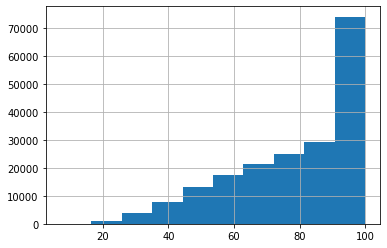

In [35]:
df['Relative Humidity'].hist()

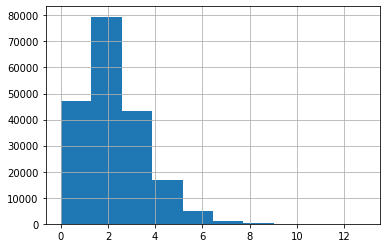

In [37]:
df['Wind Speed'].hist()

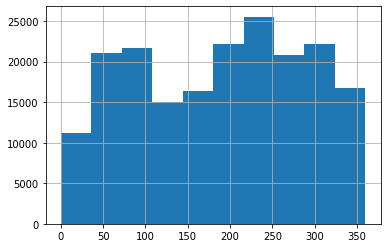

In [38]:
df['Wind Direction'].hist()

In [5]:
df['Year'].value_counts()

2012    17568
2016    17568
2009    17520
2010    17520
2011    17520
2013    17520
2014    17520
2015    17520
2017    17520
2018    17520
2019    17520
Name: Year, dtype: int64

In [5]:
df['Cloud Type'].value_counts()

0     92127
7     27207
3     17884
1     15698
8     14937
4     12596
6      8670
2      3151
9       545
10        1
Name: Cloud Type, dtype: int64

In [6]:
df['Dew Point'].value_counts()

 22.0    11787
 23.0    10948
 21.0    10327
 20.0     8552
 19.0     7871
         ...  
-9.5         2
-7.9         2
-12.4        1
 25.5        1
-9.1         1
Name: Dew Point, Length: 400, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192816 entries, 0 to 17519
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                192816 non-null  int64  
 1   Month               192816 non-null  int64  
 2   Day                 192816 non-null  int64  
 3   Hour                192816 non-null  int64  
 4   Minute              192816 non-null  int64  
 5   Clearsky DHI        175296 non-null  float64
 6   Clearsky DNI        175296 non-null  float64
 7   Clearsky GHI        175296 non-null  float64
 8   Cloud Type          192816 non-null  int64  
 9   Dew Point           192816 non-null  float64
 10  Temperature         192816 non-null  float64
 11  Pressure            192816 non-null  int64  
 12  Relative Humidity   192816 non-null  float64
 13  Solar Zenith Angle  192816 non-null  float64
 14  Precipitable Water  192816 non-null  float64
 15  Wind Direction      192816 non-null

In [7]:
feats = df.select_dtypes("number").columns
black_list = ["Clearsky DHI", "Clearsky DNI", "Clearsky GHI"]
feats = [x for x in feats if x not in black_list]

In [24]:
df_train = df[ df["Clearsky DHI"].notnull() ].copy()
df_test = df[ df["Clearsky DHI"].isnull() ].copy()

X_train = df_train[feats].values
y_train = df_train["Clearsky GHI"].values
X_test = df_test[feats].values

In [25]:
df_train["year_plus_1"] = df_train["Year"] + 1

In [26]:
df_group = df_train.groupby(["Cloud Type", "Dew Point"]).agg("mean")[ ["Clearsky GHI"] ].reset_index()

df_group.head()

,Cloud Type,Dew Point,Clearsky GHI
0,0,-17.0,532.200000
1,0,-16.0,494.666667
2,0,-15.0,257.111111
3,0,-14.0,206.137931
4,0,-13.9,595.000000


In [27]:
train_dict = { (x["Cloud Type"], x["Dew Point"]): x["Clearsky GHI"] for x in df_group.to_dict(orient="items").values() }
train_dict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  """Entry point for launching an IPython kernel.


{(0, -17.0): 532.2,
 (0, -16.0): 494.6666666666667,
 (0, -15.0): 257.1111111111111,
 (0, -14.0): 206.13793103448276,
 (0, -13.9): 595.0,
 (0, -13.8): 629.0,
 (0, -13.7): 371.0,
 (0, -13.6): 389.6666666666667,
 (0, -13.1): 541.0,
 (0, -13.0): 238.6551724137931,
 (0, -12.9): 248.5,
 (0, -12.7): 90.5,
 (0, -12.6): 307.5,
 (0, -12.5): 247.66666666666666,
 (0, -12.4): 448.0,
 (0, -12.3): 619.5,
 (0, -12.2): 1.5,
 (0, -12.1): 0.0,
 (0, -12.0): 263.4054054054054,
 (0, -11.9): 344.25,
 (0, -11.8): 0.0,
 (0, -11.7): 210.66666666666666,
 (0, -11.6): 216.0,
 (0, -11.5): 0.0,
 (0, -11.4): 97.5,
 (0, -11.3): 473.3333333333333,
 (0, -11.2): 0.0,
 (0, -11.1): 86.92307692307692,
 (0, -11.0): 314.3666666666667,
 (0, -10.9): 0.0,
 (0, -10.8): 209.33333333333334,
 (0, -10.7): 235.42857142857142,
 (0, -10.6): 156.375,
 (0, -10.5): 338.1,
 (0, -10.4): 0.0,
 (0, -10.3): 0.0,
 (0, -10.2): 287.75,
 (0, -10.1): 0.0,
 (0, -10.0): 237.35384615384615,
 (0, -9.9): 227.0,
 (0, -9.8): 207.8,
 (0, -9.7): 138.66666666

In [28]:
df_test["Clearsky GHI"] = df_test.apply(lambda x: train_dict.get( (x["Cloud Type"], x["Dew Point"]), -1), axis=1)

In [29]:
!mkdir -p ../output

In [30]:
df_test[ ["Clearsky GHI"] ].to_csv('../content/drive/MyDrive/Participants_Data_WSMLC/last_year3.csv', index=False)


In [ ]:
#y_train_log = np.log(y_train) #

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [ ]:
model = xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

[10:02:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:02:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-7.60310041555178, 0.19418644957402964)

In [ ]:
#3 model = xgb.XGBRegressor(max_depth=16, n_estimators=50, random_state=7450, colsample_bytree=0.9423172592543835, learning_rate=0.1943583561978604, min_child_weight=10, reg_alpha=2.6927834633740866, reg_lambda=0.7317831565553121, subsample=0.9025796084735125)
#2 model = xgb.XGBRegressor(max_depth=17, n_estimators=50, random_state=4000, colsample_bytree=0.9458592856498823, learning_rate=0.13569111278206655, min_child_weight=10, reg_alpha=2.237483944831808, reg_lambda=0.917249656516271, subsample=0.9084561941837783)
model = xgb.XGBRegressor(max_depth=19, n_estimators=50, random_state=3450, colsample_bytree=0.8257002166553461, learning_rate=0.1610290083374596, min_child_weight=9, reg_alpha=1.7373348984291654, reg_lambda=0.729011789851616, subsample=0.9349139823065598)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred[ y_pred < 0 ] = 0
df_test["Clearsky DHI"] = y_pred

[15:50:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#y_train_log = np.log(y_train)
#model = xgb.XGBRegressor(max_depth=16, n_estimators=50, random_state=7450, colsample_bytree=0.9423172592543835, learning_rate=0.1943583561978604, min_child_weight=10, reg_alpha=2.6927834633740866, reg_lambda=0.7317831565553121, subsample=0.9025796084735125)
#model.fit(X_train, y_train_log)

#y_pred = np.exp(model.predict(X_test))
#y_pred[ y_pred < 0 ] = 0
#df_test["Clearsky DHI"] = y_pred

#df_test["Clearsky DHI"] = np.exp(model.predict(X_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


[10:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
!mkdir -p ../output

In [ ]:
df_test[ ["Clearsky DHI"] ].to_csv('../content/drive/MyDrive/Participants_Data_WSMLC/simple_xgboost_1_d.csv', index=False) 

In [ ]:
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

In [ ]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [25:06<00:00, 50.22s/it, best loss: 3.6165509619343386]
The best params:  {'x_colsample_bytree': 0.8257002166553461, 'x_learning_rate': 0.1610290083374596, 'x_max_depth': 19.0, 'x_min_child_weight': 9.0, 'x_random_state': 3450.0, 'x_reg_alpha': 1.7373348984291654, 'x_reg_lambda': 0.729011789851616, 'x_subsample': 0.9349139823065598}
